In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
first = pd.read_json('PROCESSED_VIDEO_DATA.json',orient='index')

In [3]:
second = pd.read_json('PROCESSED_VIDEO_DATA1.json',orient='index')

In [4]:
def get_removed_index_from_landmarks(right_hand,left_hand):
    removed_indexes = []
    for i in range(len(right_hand)):
        if(len(right_hand) - len(removed_indexes) <=60):
            break
        if(right_hand[i] == None and left_hand[i] == None):
            removed_indexes.append(i)
    return removed_indexes

def get_removed_index_from_world_landmarks(right_hand,left_hand):
    removed_indexes = []
    # print(len(right_hand))
    for i in range(len(right_hand)):
        
        if(len(right_hand) - len(removed_indexes) <=60):
            break
        # print(i,right_hand[i][0] == None and left_hand[i][0] == None)
        if(right_hand[i][0] == None and left_hand[i][0] == None):
            removed_indexes.append(i)
    return removed_indexes

def convert_to_60_frames(data):
    for item in data.iterrows():
        # remove_indexes = get_removed_index_from_landmarks(item[1].RIGHT_HAND_LANDMARKS,item[1].LEFT_HAND_LANDMARKS)
        # print(item)
        world_remove_indexes = get_removed_index_from_world_landmarks(item[1].RIGHT_HAND_WORLD_LANDMARKS,item[1].LEFT_HAND_WORLD_LANDMARKS)

        if(len(item[1].RIGHT_HAND_WORLD_LANDMARKS)<60):
            current_length = len(item[1].RIGHT_HAND_WORLD_LANDMARKS)
            for i in range(current_length,60):
                item[1].RIGHT_HAND_WORLD_LANDMARKS.append([None])
                item[1].LEFT_HAND_WORLD_LANDMARKS.append([None])
                item[1].POSE_WORLD_LANDMARKS.append([None])

        
        for index in sorted(world_remove_indexes, reverse=True):
            del item[1].RIGHT_HAND_WORLD_LANDMARKS[index]
            del item[1].LEFT_HAND_WORLD_LANDMARKS[index]
            del item[1].POSE_WORLD_LANDMARKS[index]
            
        if(len(item[1].RIGHT_HAND_WORLD_LANDMARKS)>60):
            del item[1].RIGHT_HAND_WORLD_LANDMARKS[60:]
            del item[1].LEFT_HAND_WORLD_LANDMARKS[60:]
            del item[1].POSE_WORLD_LANDMARKS[60:]
            
convert_to_60_frames(first)
convert_to_60_frames(second)

In [5]:
#Loop throug data
sequences = []
labels = []
import numpy as np
def extract_keypoints(pose_world_landmarks,right_hand_world_landmarks,left_hand_world_landmarks):
    pose = np.array([[res['X'], res['Y']] for res in pose_world_landmarks]).flatten() if pose_world_landmarks[0] else np.zeros(12*2)
    lh = np.array([[res['X'], res['Y'], res['Z']] for res in left_hand_world_landmarks ]).flatten() if left_hand_world_landmarks[0] else np.zeros(21*3)
    rh = np.array([[res['X'], res['Y'], res['Z']] for res in right_hand_world_landmarks ]).flatten() if right_hand_world_landmarks[0] else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

def convert_world_to_2d_array(data):
    k = 0;
    for item in data.iterrows():
        sequence = []
        labels.append(item[1].Label)
        for i in range(len(item[1].RIGHT_HAND_WORLD_LANDMARKS)):    
            pose_world = item[1].POSE_WORLD_LANDMARKS[i];
            if pose_world == None:
                pose_world = [None]
            points = extract_keypoints(pose_world,item[1].RIGHT_HAND_WORLD_LANDMARKS[i],item[1].LEFT_HAND_WORLD_LANDMARKS[i])
            sequence.append(points)
        sequences.append(sequence)
        k= k+1
convert_world_to_2d_array(first)
convert_world_to_2d_array(second)



In [10]:

X = np.array(sequences)
words = np.array(labels).reshape(-1,1)
Y = OneHotEncoder().fit_transform(words).toarray()


In [14]:
with open('DATA1.npy', 'wb') as f:
    np.save(f, X)
    
with open('LABELS1.npy', 'wb') as f:
    np.save(f, words)
    
    

In [23]:
np1 = np.load("DATA1.npy")
labels = np.load("LABELS1.npy")
np1.shape,labels.shape

((5000, 60, 150), (5000, 1))

In [51]:
X_train, X_test , y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=69,stratify=Y)

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
import os
import tensorflow as tf
from numpy.random import seed
from tensorflow.keras import regularizers




log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [53]:
seed(69)
tf.random.set_seed(69)
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(60,150)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(Y.shape[1], activation='softmax'))

In [54]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
history = model.fit(X_train, y_train, epochs=2000,validation_split = 0.2,verbose = 0)

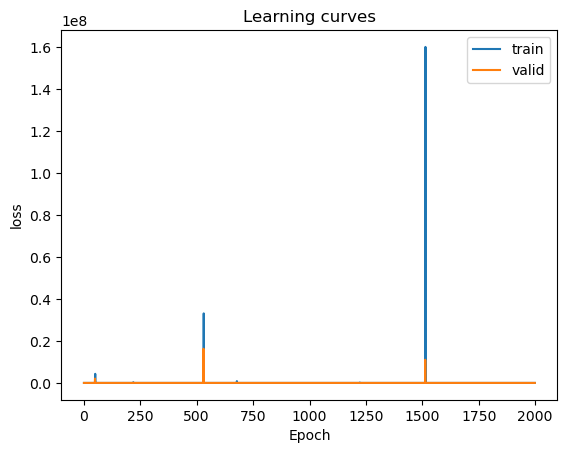

In [56]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.show()

In [43]:
print("Accuracy on training data: {}".format(model.evaluate(X_train, y_train)))
print("Accuracy on test data: {}".format(model.evaluate(X_test, y_test)))

1/1 [==============================] - 0s 51ms/step - loss: 0.6939 - accuracy: 0.9677
Accuracy on training data: [0.6938652396202087, 0.9677419066429138]
1/1 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Accuracy on test data: [0.0, 1.0]
